In [2]:
from project_lib.genotype_simulation import *
from project_lib.stat_functions import *

In [4]:
#visualize pedigrees
def draw_pedigree(ped_ts):
    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

In [5]:
pb = msprime.PedigreeBuilder(
    individuals_metadata_schema=tskit.MetadataSchema.permissive_json())
mom_id = pb.add_individual(time=1, metadata={"name": "mom"})
dad_id = pb.add_individual(time=1, metadata={"name": "dad"})
pb.add_individual(
    time=0, parents=[mom_id, dad_id], is_sample=True, metadata={"name": "child"})
pedigree = pb.finalise()
display(pedigree.nodes)

id,flags,population,individual,time,metadata
0,0,0,0,1,
1,0,0,0,1,
2,0,0,1,1,
3,0,0,1,1,
4,1,0,2,0,
5,1,0,2,0,


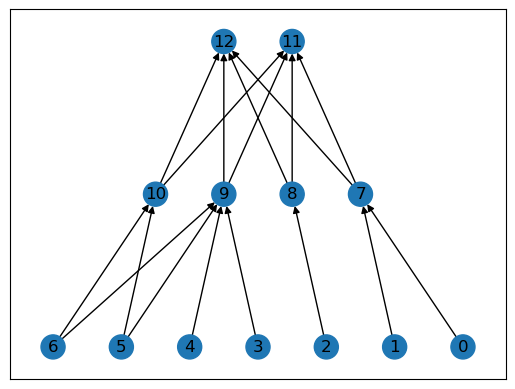

In [6]:
#example pedigrees
#id doesnt matter except for parent child relationships
ped_txt = """\
# id parent0 parent1 time
0 7 7 0.0
1 7 7 0.0
2 8 8 0.0
3 9 9 0.0
4 9 9 0.0
5 10 9 0.0
6 10 9 0.0
7 11 12 1.0
8 11 12 1.0
9 11 12 1.0
10 11 12 1.0
11 . . 2.0
12 . . 2.0
"""

pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length = 100)

draw_pedigree(pedigree.tree_sequence())

In [7]:
ped_sim = msprime.sim_ancestry(
    initial_state=pedigree, model="fixed_pedigree", random_seed=42, recombination_rate = 0.001, ploidy = 2)

In [9]:
type(ped_sim)

tskit.trees.TreeSequence

In [8]:
#define functions for building pedigrees for breeding

#transform text to pd df
#df = pd.read_table(io.StringIO(ped_txt))
#transform pd df to text
#print(df.to_string())

#generate pedigree df with n "founder" individuals
def pedigree_init(n = 10):
    pedigree = pd.DataFrame(
    {"id": [i for i in range(0, n)],
    "parent0": ["."]*n,
    "parent1": ["."]*n,
    "time": [0]*n})
    return pedigree

#generate msprime trees from df
def df_to_ts(df, seq_len = 100):
    ped_string = df.to_string(index = False)
    ts_ped = msprime.parse_pedigree(io.StringIO("#" + ped_string), sequence_length = seq_len)
    return ts_ped

#selfing (adding selfed individual to pedigree)
def add_selfing(df, size_diff = 0):
    df['time'] += 1
    parents = df.loc[df['time'] == df['time'].min(), "id"].to_numpy()
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + len(parents) + size_diff)]
    df = pd.concat(objs=(df, pd.DataFrame({"id" : ids, "parent0": np.resize(parents, len(parents) + size_diff),
                                           "parent1": np.resize(parents, len(parents) + size_diff),
                                           "time" : [0]*(len(parents) + size_diff)}))).reset_index(drop = True)
    return(df)

#random mating
#implement chance of selfing
def add_random_mating(df, size_diff = 0):
    df['time'] += 1
    parents = df.loc[df['time'] == df['time'].min(), "id"].to_numpy()
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + len(parents) + size_diff)]
    df = pd.concat(objs=(df, pd.DataFrame({"id" : ids, "parent0": np.random.choice(parents, len(parents) + size_diff),
                                           "parent1": np.random.choice(parents, len(parents) + size_diff),
                                           "time" : [0]*(len(parents) + size_diff)}))).reset_index(drop = True)
    return(df)
    
#selective mating
def add_selective_mating(df, parents, offspring = 1):
    df['time'] += 1
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + offspring)]
    df = pd.concat(objs=(df, pd.DataFrame({"id": ids, "parent0": np.resize(parents[0], offspring),
                                           "parent1": np.resize(parents[1], offspring),
                                           "time": [0]*offspring}))).reset_index(drop = True)     
    return(df)


#combine n choose 2 (assuming two different parents) or list of crosses. out: n choose 2 pb classes

In [269]:
df = pedigree_init(2)

In [270]:
df = add_random_mating(df, size_diff = 7)

In [271]:
df = add_selfing(df)
df = add_selfing(df)
df = add_selfing(df)

In [272]:
df

,id,parent0,parent1,time
0,0,.,.,4
1,1,.,.,4
2,2,0,1,3
3,3,1,1,3
4,4,1,0,3
5,5,0,1,3
6,6,0,0,3
7,7,0,1,3
8,8,1,0,3
9,9,0,0,3


In [55]:
#add_selective_mating(df, list([10,11]), offspring = 5)

In [56]:
#add_selfing(df, size_diff = 5)

In [57]:
#add_random_mating(df, size_diff = 5)

In [273]:
test_ts = df_to_ts(df, 297570924)

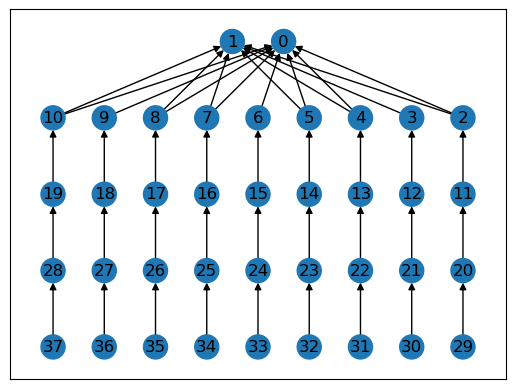

In [274]:
draw_pedigree(test_ts.tree_sequence())

In [275]:
test_arg = msprime.sim_ancestry(
    initial_state=test_ts, model="fixed_pedigree", random_seed=42, recombination_rate = 0.00000009)

In [276]:
#print ancestry
def draw_ancestry(ts):
    node_labels = {node.id: f"{node.individual}({node.id})" for node in ts.nodes()}
    SVG(ts.draw_svg(y_axis=True,  node_labels=node_labels, size=(4000,200)))

In [277]:
draw_ancestry(test_arg)

ValueError: Image size too small to fit

In [278]:
test_arg.breakpoints(as_array = True)

array([0.00000000e+00, 1.71366000e+05, 8.71461000e+05, ...,
       2.97315117e+08, 2.97509366e+08, 2.97570924e+08])

In [279]:
segments = test_arg.ibd_segments(store_pairs = True, store_segments = True)
for pair, value in segments.items():
    print(pair, "::", value)
print(segments)

(58, 59) :: IdentitySegmentList(num_segments=83, total_span=264606361.0)
(58, 60) :: IdentitySegmentList(num_segments=79, total_span=80478476.0)
(58, 61) :: IdentitySegmentList(num_segments=77, total_span=80275296.0)
(58, 62) :: IdentitySegmentList(num_segments=84, total_span=66260732.0)
(58, 63) :: IdentitySegmentList(num_segments=84, total_span=62762463.0)
(58, 64) :: IdentitySegmentList(num_segments=107, total_span=108930733.0)
(58, 65) :: IdentitySegmentList(num_segments=109, total_span=108784621.0)
(58, 66) :: IdentitySegmentList(num_segments=81, total_span=82158909.0)
(58, 67) :: IdentitySegmentList(num_segments=80, total_span=81481578.0)
(58, 68) :: IdentitySegmentList(num_segments=93, total_span=106936109.0)
(58, 69) :: IdentitySegmentList(num_segments=97, total_span=97590857.0)
(58, 70) :: IdentitySegmentList(num_segments=70, total_span=68005150.0)
(58, 71) :: IdentitySegmentList(num_segments=61, total_span=63870298.0)
(58, 72) :: IdentitySegmentList(num_segments=90, total_spa

In [280]:
#segments

In [281]:
print(test_arg.dump_tables())

TableCollection

Sequence Length: 297570924.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤═════════════════╗
║id│flags│location│parents│metadata         ║
╠══╪═════╪════════╪═══════╪═════════════════╣
║0 │    0│        │ -1, -1│ {'file_id': '0'}║
║1 │    0│        │ -1, -1│ {'file_id': '1'}║
║2 │    0│        │   0, 1│ {'file_id': '2'}║
║3 │    0│        │   1, 1│ {'file_id': '3'}║
║4 │    0│        │   1, 0│ {'file_id': '4'}║
║5 │    0│        │   0, 1│ {'file_id': '5'}║
║6 │    0│        │   0, 0│ {'file_id': '6'}║
║7 │    0│        │   0, 1│ {'file_id': '7'}║
║8 │    0│        │   1, 0│ {'file_id': '8'}║
║9 │    0│        │   0, 0│ {'file_id': '9'}║
║10│    0│        │   0, 1│{'file_id': '10'}║
║11│    0│        │   2, 2│{'file_id': '11'}║
║12│    0│        │   3, 3│{'file_id': '12'}║
║13│    0│        │   4, 4│{'file_id': '13'}║
║14│    0│        │   5, 5│{'file_id': '14'}║
║15│    0│        │   6, 6│{'file_id': '15'}║
║16│    0│        │   7, 7│{'

In [282]:
#get genos
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")
#parent_genos

In [283]:
#read_hapmap function to read recombination rates
def get_rate_map(genmap):
    genmap = genmap[["Chromosome", "Position(bp)", "Rate(cM/Mb)", "Map(cM)"]]
    return(msprime.RateMap.read_hapmap(io.StringIO(genmap.to_string(index = False))))

In [284]:
genmap = pd.read_csv("data/test_data/B73_genmap_chr1.csv")
chr1_rate_map = get_rate_map(genmap)

#load snp positions
SNP_positions = pd.read_csv("data/test_data/NAM_SNP_positions.csv")
chr_1_SNP_positions = SNP_positions[SNP_positions["Marker"].isin(genmap["Marker"])]
chr_1_SNP_positions

,Marker,Chromosome,Position(bp)
0,PZA01271.1,1,1947984
1,PZA03613.1,1,2914171
2,PZA02129.1,1,3706018
3,PZA02032.1,1,4490461
4,PHM2244.142,1,5562502
...,...,...,...
171,PZA00243.25,1,295771335
172,PZA00856.2,1,295785198
173,PZA01239.2,1,296854434
174,PZA01807.1,1,297315711


In [293]:
#propagate geno functions
def get_set(ts):
    return(list(set(ts.edges_parent).union(set(ts.edges_child))))

def get_founders(ts):
    return(list(set(ts.edges_parent) - set(ts.edges_child)))

def get_offspring(ts):
    return(list(set(ts.edges_child) - set(ts.edges_parent)))

def get_edges(parents, ts):
    pc_df = pd.DataFrame({"left": ts.edges_left, "right": ts.edges_right, "parent" : ts.edges_parent, "child" : ts.edges_child})
    children = pc_df.loc[pc_df["parent"].isin(parents),]
    return(children)
    
#function to choose founders and split diploid genome into ts nodes -> output genoypes df to use in propagate_geno function
def get_founder_nodes(genotypes, founders):
    founder_geno = genotypes.loc[genotypes['RIL'].isin(founders)].drop("RIL", axis = 1)
    founder_nodes = pd.concat([founder_geno.loc[0].str[0],
                              founder_geno.loc[0].str[2],
                              founder_geno.loc[1].str[0],
                              founder_geno.loc[1].str[2]], axis = 1).T.reset_index(drop = True)
    return founder_nodes

#add typing!!
def propagate_geno(arg, founder_nodes, snp_pos):
    sites = snp_pos["Marker"]
    geno_sim = pd.DataFrame(columns = list(["node"]) + list(sites))
    geno_sim["node"] = get_set(arg)
    founders = get_founders(arg)
    founder_nodes = founder_nodes[sites]
    
    for i in range(0, len(founders)):
        geno_sim.loc[geno_sim["node"] == founders[i], sites] = list(founder_nodes.iloc[founders[i]])

    edges = get_edges(founders, arg)

    while edges.empty != True:
        for i in range(0, len(edges["parent"])):
            snps = snp_pos.loc[(snp_pos['Position(bp)'] >= edges.iloc[i]["left"]) & (snp_pos['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
            geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]
        edges = get_edges(edges["child"], arg)
        #calculate summary statistics for current generation here
        #make df with generation key col + stats col
        #e.g. heterozygosity (decrease in selfing genos) selfing metrics see paper
    
    return(geno_sim)

def get_offspring_geno(arg, geno_sim):
    return(geno_sim.loc[geno_sim["node"].isin(get_offspring(arg))])

In [294]:
founder_nodes = get_founder_nodes(parent_genos, list(["B73", "B97"]))

In [242]:
#genmap = genmap.loc[genmap['Position(bp)'] <= 10000000]

In [295]:
geno_sim = propagate_geno(test_arg, founder_nodes, chr_1_SNP_positions)

In [296]:
get_offspring_geno(test_arg, geno_sim)

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
58,58,G,T,C,A,C,T,A,G,A,...,T,G,C,A,A,G,T,A,G,C
59,59,G,T,C,T,C,T,A,T,C,...,T,C,C,A,A,G,T,A,G,C
60,60,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
61,61,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
62,62,C,A,T,T,C,T,A,G,A,...,T,G,C,G,C,A,T,A,G,T
63,63,C,A,T,T,C,T,A,G,A,...,T,G,C,G,C,A,T,A,G,T
64,64,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,T
65,65,C,A,C,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,T
66,66,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
67,67,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C


In [222]:
sites = genmap["Marker"]

In [223]:
geno_sim = pd.DataFrame(columns = list(["node"]) + list(sites))

In [224]:
geno_sim["node"] = get_set(test_arg)

In [225]:
founders = get_founders(test_arg)

In [226]:
founder_nodes = get_founder_nodes(parent_genos, list(["B73", "B97"]))

In [227]:
founder_nodes = founder_nodes[sites]

In [228]:
for i in range(0, len(founders)):
        geno_sim.loc[geno_sim["node"] == founders[i], sites] = list(founder_nodes.iloc[founders[i]])

In [229]:
geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,PZA00447.8,PZA02284.1,PZA00731.7
0,0,C,A,T,T,C,T,A,G,A,T,C,C,A
1,1,C,A,T,T,C,T,A,G,A,T,C,C,A
2,2,G,T,C,A,G,T,A,T,C,T,T,C,A
3,3,G,T,C,A,G,T,A,T,C,T,T,C,A
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
edges = get_edges(founders, test_arg)

In [231]:
edges

,left,right,parent,child
28,0.0,2251651.0,0,5
29,1884721.0,3769125.0,0,7
30,4939488.0,5604364.0,0,7
31,8657.0,2251239.0,0,15
32,6281836.0,10000000.0,0,15
33,0.0,4150518.0,0,18
34,2251651.0,5214090.0,0,22
35,0.0,1884721.0,0,24
36,3769125.0,4939488.0,0,24
37,5604364.0,10000000.0,0,24


In [232]:
for i in range(0, len(edges["parent"])):
    snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
    geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]

In [40]:
#snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[0]["left"]) & (genmap['Position(bp)'] <= edges.iloc[0]["right"]), "Marker"]

In [41]:
#geno_sim.loc[geno_sim["node"] == edges.iloc[0]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[0]["parent"], snps].values[0]


In [233]:
genmap

,Marker,Chromosome,Position(bp)
0,PZA01271.1,1,1947984
1,PZA03613.1,1,2914171
2,PZA02129.1,1,3706018
3,PZA02032.1,1,4490461
4,PHM2244.142,1,5562502
5,PZA02372.1,1,6220547
6,PHM6238.36,1,7156367
7,PZA00181.2,1,8366411
8,PZA00528.1,1,8367944
9,PZA00175.2,1,8510027


In [234]:
geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,PZA00447.8,PZA02284.1,PZA00731.7
0,0,C,A,T,T,C,T,A,G,A,T,C,C,A
1,1,C,A,T,T,C,T,A,G,A,T,C,C,A
2,2,G,T,C,A,G,T,A,T,C,T,T,C,A
3,3,G,T,C,A,G,T,A,T,C,T,T,C,A
4,4,NaN,NaN,NaN,NaN,G,T,A,T,C,T,T,C,A
5,5,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,C,A,T,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,G,T,C,A,G,T,A,T,C,T,T,C,A
8,11,G,T,C,A,G,T,A,T,C,T,T,C,A
9,15,C,NaN,NaN,NaN,NaN,NaN,A,G,A,T,C,C,A


In [235]:
edges = get_edges(edges["child"], test_arg)

In [236]:
for i in range(0, len(edges["parent"])):
    snps = genmap.loc[(genmap['Position(bp)'] >= edges.iloc[i]["left"]) & (genmap['Position(bp)'] <= edges.iloc[i]["right"]), "Marker"]
    geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]

In [237]:
geno_sim

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,PZA00447.8,PZA02284.1,PZA00731.7
0,0,C,A,T,T,C,T,A,G,A,T,C,C,A
1,1,C,A,T,T,C,T,A,G,A,T,C,C,A
2,2,G,T,C,A,G,T,A,T,C,T,T,C,A
3,3,G,T,C,A,G,T,A,T,C,T,T,C,A
4,4,NaN,NaN,NaN,NaN,G,T,A,T,C,T,T,C,A
5,5,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,C,A,T,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,G,T,C,A,G,T,A,T,C,T,T,C,A
8,11,G,T,C,A,G,T,A,T,C,T,T,C,A
9,15,C,NaN,NaN,NaN,NaN,NaN,A,G,A,T,C,C,A


In [238]:
get_edges(edges["child"], test_arg)

,left,right,parent,child


In [239]:
geno_sim.loc[geno_sim["node"].isin(get_offspring(test_arg))]

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,PZA00447.8,PZA02284.1,PZA00731.7
14,22,C,A,T,T,G,T,A,T,C,T,T,C,A
15,23,C,T,C,A,G,T,A,T,C,T,T,C,A
16,24,C,A,T,T,C,T,A,G,A,T,C,C,A
17,25,C,A,T,A,C,T,A,T,C,T,T,C,A
18,26,G,T,C,A,G,T,A,T,C,T,T,C,A
19,27,G,T,C,A,G,T,A,T,C,T,T,C,A
20,28,G,T,C,A,G,T,A,T,C,T,T,C,A
21,29,G,T,C,A,G,T,A,T,C,T,T,C,A
22,30,C,A,T,T,C,T,A,G,A,T,C,C,A
23,31,C,A,T,T,C,T,A,G,A,T,C,C,A


In [33]:
print(ped_ts.dump_tables())

TableCollection

Sequence Length: 100.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤═════════════════╗
║id│flags│location│parents│metadata         ║
╠══╪═════╪════════╪═══════╪═════════════════╣
║0 │    0│        │ -1, -1│ {'file_id': '0'}║
║1 │    0│        │ -1, -1│ {'file_id': '1'}║
║2 │    0│        │ -1, -1│ {'file_id': '2'}║
║3 │    0│        │ -1, -1│ {'file_id': '3'}║
║4 │    0│        │ -1, -1│ {'file_id': '4'}║
║5 │    0│        │   0, 0│ {'file_id': '5'}║
║6 │    0│        │   1, 1│ {'file_id': '6'}║
║7 │    0│        │   2, 2│ {'file_id': '7'}║
║8 │    0│        │   3, 3│ {'file_id': '8'}║
║9 │    0│        │   4, 4│ {'file_id': '9'}║
║10│    0│        │   5, 5│{'file_id': '10'}║
║11│    0│        │   6, 6│{'file_id': '11'}║
║12│    0│        │   7, 7│{'file_id': '12'}║
║13│    0│        │   8, 8│{'file_id': '13'}║
║14│    0│        │   9, 9│{'file_id': '14'}║
║15│    0│        │ 10, 10│{'file_id': '15'}║
║16│    0│        │ 11, 11│{'file_i

In [20]:
#selection step (see essentials of plant breeding) prune pedigree
#either stepwise (prediction and selection in each step with caveats (only possible in selfing generations))
#or simulate entire breeding ibds and predict final phenotype, simulate all generations

In [21]:
#predict Y (see rf or dl files)

In [ ]:
#tskit examples

In [51]:
nodes = """\
id      is_sample   time
0       1           0
1       1           0
2       1           0
3       1           0
4       1           0
5       0           1
6       0           2
7       0           3
"""
edges = """\
left    right   parent  child
0       60      5       4,3
0       40      6       2
0       60      6       1,0
20      40      6       5
0       20      7       5
40      60      7       5
0       60      7       6
40      60      7       2
"""
sites = """\
position	ancestral_state	metadata
2.000000	A	
4.000000	A	
"""

In [52]:
sites_ts = tskit.load_text(nodes = io.StringIO(nodes), edges = io.StringIO(edges), sites = io.StringIO(sites), strict = False)

In [137]:
ped_ts.dump_tables().sites

id,position,ancestral_state,metadata


In [180]:
print(ped_ts.dump_tables())

TableCollection

Sequence Length: 100.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤════════════════╗
║id│flags│location│parents│metadata        ║
╠══╪═════╪════════╪═══════╪════════════════╣
║0 │    0│        │ -1, -1│{'file_id': '0'}║
║1 │    0│        │ -1, -1│{'file_id': '1'}║
║2 │    0│        │ -1, -1│{'file_id': '2'}║
║3 │    0│        │ -1, -1│{'file_id': '3'}║
║4 │    0│        │ -1, -1│{'file_id': '4'}║
║5 │    0│        │   4, 2│{'file_id': '5'}║
║6 │    0│        │   4, 2│{'file_id': '6'}║
║7 │    0│        │   3, 0│{'file_id': '7'}║
║8 │    0│        │   1, 2│{'file_id': '8'}║
║9 │    0│        │   2, 4│{'file_id': '9'}║
╚══╧═════╧════════╧═══════╧════════════════╝

Nodes
╔══╤═════╤══════════╤══════════╤════╤════════╗
║id│flags│population│individual│time│metadata║
╠══╪═════╪══════════╪══════════╪════╪════════╣
║0 │    0│         0│         0│   1│        ║
║1 │    0│         0│         0│   1│        ║
║2 │    0│         0│         1│   1│

In [181]:
for i, h in enumerate(ped_ts.haplotypes()):
    print(f"Sample {i}: {h}")

Sample 0: AGT
Sample 1: AGT
Sample 2: AGT
Sample 3: AGT
Sample 4: AGT
Sample 5: AGT
Sample 6: AGT
Sample 7: AGT
Sample 8: AGT
Sample 9: AGT


In [27]:
sites_ts.roots()

AttributeError: 'TreeSequence' object has no attribute 'roots'